## Generative Adversarial Networks -- Mnist Dataset

In [61]:
import tensorflow as tf
import numpy as np 
import matplotlib 

In [62]:
tf.__version__, np.__version__, matplotlib.__version__

('2.17.0', '1.26.4', '3.9.2')

In [63]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape
from tensorflow.keras.regularizers import L1L2
import matplotlib.pyplot as plt

In [64]:
(X_train, _),(_, _) = mnist.load_data()

In [65]:
X_train = X_train.astype('float32')/255

In [66]:
X_train.max(), X_train.min(), X_train.mean()

(1.0, 0.0, 0.13066062)

In [67]:
X_train.shape

(60000, 28, 28)

In [68]:
# creating a dataset in tensorflow format 

X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=60000).batch(batch_size=256)

In [69]:
60000/256

234.375

In [70]:
# now we have a train dataset within a tensorflow class

type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [71]:
# Generator 

# 100 -> 500 -> 500
generator = Sequential()
generator.add(Dense(units=500, input_dim=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Dense(units=500, input_dim=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Dense(units=784, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Reshape((28, 28)))
generator.summary()


c:\Users\Matheus\Documents\GitHub\ai-experiments\ai-exp\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 500)            │        50,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 784)            │       392,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,784 (2.65 MB)

 Trainable params: 693,784 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Discriminator 

# (28, 28)/784 -> 500 -> 500 -> 1
discriminator = Sequential()
discriminator.add(InputLayer(input_shape=(28,28)))
discriminator.add(Flatten())
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))

discriminator.summary()

c:\Users\Matheus\Documents\GitHub\ai-experiments\ai-exp\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,501 (2.45 MB)

 Trainable params: 643,501 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [74]:
# it is gonna measure how much discriminator predictions are close to 1 

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [75]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [76]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [77]:
epochs = 100
noise_dim = 100 # we have 100 neurons in the input layer

In [78]:
tf.random.normal([256, noise_dim])

<tf.Tensor: shape=(256, 100), dtype=float32, numpy=
array([[-0.5907858 ,  0.35866418,  0.32885438, ...,  0.6226863 ,
         2.4536033 , -0.90571827],
       [-1.4267029 ,  0.9309731 , -0.3299844 , ..., -0.7497519 ,
        -0.5760556 ,  3.3015347 ],
       [-1.5189477 ,  0.7388165 , -1.4534513 , ..., -2.2025883 ,
         1.3042381 , -0.40322277],
       ...,
       [ 0.907863  ,  1.092522  , -0.374556  , ..., -1.7262622 ,
        -0.45970356,  0.23841552],
       [-1.0499623 , -1.4414288 ,  0.9493083 , ...,  2.7751868 ,
         1.683036  ,  1.0008816 ],
       [-1.1639882 , -0.99781007, -0.21190591, ...,  1.1629606 ,
        -0.334491  , -1.0740695 ]], dtype=float32)>

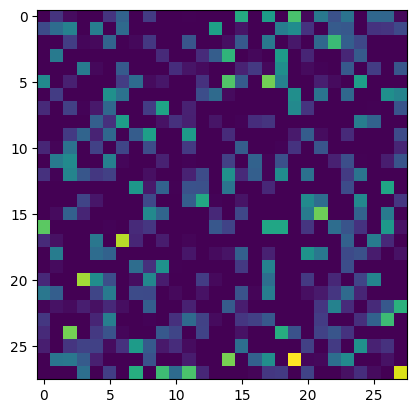

In [79]:
# random image (noise) that we are goint to pass throught the generator

plt.imshow(generator(tf.random.normal([256, noise_dim]))[2]);

In [80]:
def train_step(images):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss
    

In [81]:
for epoch in range(epochs):
    for image_batch in X_train:
        gen_loss_batch, disc_loss_batch = train_step(image_batch)
    print(f'Epoch {epoch} | gen_loss: {gen_loss_batch} disc_loss {disc_loss_batch}')


Epoch 0 | gen_loss: 3.8674402236938477 disc_loss 0.1488165557384491
Epoch 1 | gen_loss: 5.8216872215271 disc_loss 0.01482794526964426
Epoch 2 | gen_loss: 6.657279968261719 disc_loss 0.01357210148125887
Epoch 3 | gen_loss: 6.526099681854248 disc_loss 0.011182225309312344
Epoch 4 | gen_loss: 4.974071025848389 disc_loss 0.01744530163705349
Epoch 5 | gen_loss: 2.9719252586364746 disc_loss 0.10013769567012787
Epoch 6 | gen_loss: 5.05580997467041 disc_loss 0.016687065362930298
Epoch 7 | gen_loss: 6.338765621185303 disc_loss 0.004753573331981897
Epoch 8 | gen_loss: 5.731046676635742 disc_loss 0.0062253354117274284
Epoch 9 | gen_loss: 7.694082736968994 disc_loss 0.008658895269036293
Epoch 10 | gen_loss: 8.01639461517334 disc_loss 0.0030683225486427546
Epoch 11 | gen_loss: 7.734509468078613 disc_loss 0.005995563231408596
Epoch 12 | gen_loss: 8.366600036621094 disc_loss 0.0014915532665327191
Epoch 13 | gen_loss: 8.497197151184082 disc_loss 0.0034832628443837166
Epoch 14 | gen_loss: 8.09670162200

KeyboardInterrupt: 